In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from cvx.covariance.combination import from_sigmas, iterated_ewma
from cvx.covariance.ewma import _ewma_cov, _ewma_mean, iterated_ewma
from cvx.covariance.regularization import *
from experiments.utils.experiment_utils import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
returns = pd.read_csv('../data/HF_Returns_Stocks.csv', index_col=0, parse_dates=True, encoding='latin1', skiprows=1)

nyse_tickers_temp = [
    'JPM', 'GS', 'KO', 'DIS', 'IBM', 'CAT', 'CVX', 'XOM', 'T', 'GE',
    'MRK', 'VZ', 'PFE', 'WMT', 'C', 'HD', 'BA', 'UNH', 'MMM', 'TRV',
    'MCD', 'NKE', 'AAP', 'V', 'JNJ', 'INTC', 'MSFT', 'AAPL', 'GOOGL', 'AMZN',
    'BRK.B', 'CSCO', 'TSLA', 'PG', 'ABT', 'VLO', 'RTX', 'HON', 'LMT', 'TXN',
    'COST', 'PEP', 'UNP', 'WFC', 'CVS', 'ORCL', 'XRX', 'TMO', 'NSC'
]

nyse_tickers = [ticker for ticker in nyse_tickers_temp if ticker in returns.columns]

returns = returns[nyse_tickers]

daily_returns = returns.groupby('Date').apply(lambda x: (1 + x).cumprod() - 1).groupby("Date").last()

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [5]:
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(daily_returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, daily_returns, means=None).solve(window=10))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

In [8]:
halflives = [1, 5, 10, 21, 63]

# CM-IEWMA
ewmas = {f"{halflife}": list(realized_ewma(returns, halflife=halflife)) for halflife in halflives}
Sigmas = {key: {time: cov for time, cov in ewma} for key, ewma in ewmas.items()}

results = list(from_sigmas(Sigmas, daily_returns, means=None).solve(window=21))

cm_ewma_real = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

In [9]:
start_date = daily_returns.index[500]
end_date = daily_returns.index[-1]

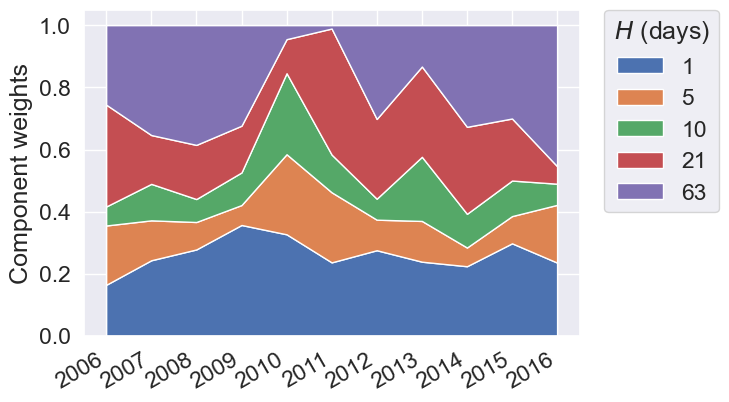

In [10]:
yearly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{halflife}" for halflife in halflives])
plt.ylabel("Component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H$ (days)")
plt.gcf().autofmt_xdate();

In [11]:
# Prescient 
prescient = {}
for t in daily_returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(daily_returns.loc[(daily_returns.index.year == t.year) & (daily_returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(daily_returns.loc[(daily_returns.index.year == t.year) & (daily_returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=daily_returns.columns, columns=daily_returns.columns)

In [12]:
real_ewma = dict(realized_ewma(returns, halflife=10))

In [13]:
ewma = dict(_ewma_cov(daily_returns, halflife=250))

In [14]:
ewma = {time: ewma[time] for time in ewma if time >= start_date}
real_ewma = {time: real_ewma[time] for time in real_ewma if time >= start_date}
cm_ewma_real = {time: cm_ewma_real[time] for time in cm_ewma_real if time >= start_date}
cm_iewma = {time: cm_iewma[time] for time in cm_iewma if time >= start_date}

prescient = {time: prescient[time] for time in prescient if time >= start_date}

In [15]:
predictors = [cm_iewma, real_ewma, cm_ewma_real, prescient]
names = ["CM-IEWMA", "REWMA", "CM-REWMA", "PRESCIENT"]

# MSEs

In [16]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(daily_returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")


CM-IEWMA
mean: 0.000314
std: 0.001178
max: 0.007587

REWMA
mean: 0.000302
std: 0.001135
max: 0.007300

CM-REWMA
mean: 0.000299
std: 0.001123
max: 0.007231

PRESCIENT
mean: 0.000295
std: 0.001105
max: 0.007103


# Regret

In [17]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = daily_returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing CM-IEWMA log-likelihood...
Computing REWMA log-likelihood...
Computing CM-REWMA log-likelihood...
Computing PRESCIENT log-likelihood...


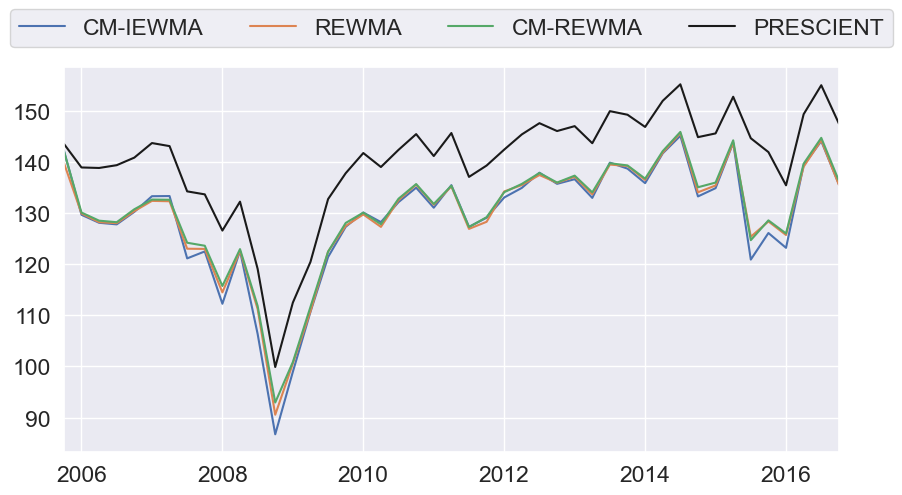

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
# plt.ylim(50,92);

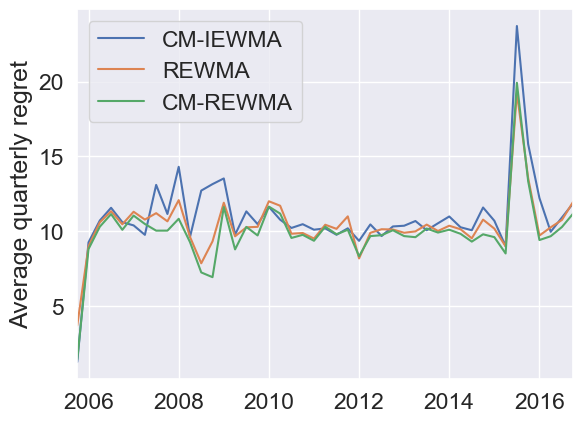

In [19]:
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()
regret_rewma = regrets["REWMA"].resample("Q").mean()
regret_cm_rewma = regrets["CM-REWMA"].resample("Q").mean()

regret_cm_iewma.plot(label="CM-IEWMA")
regret_rewma.plot(label="REWMA")
regret_cm_rewma.plot(label="CM-REWMA")
plt.ylabel("Average quarterly regret")
plt.legend();

In [20]:
cm_rewma_advantage1 = (regret_cm_rewma - regret_rewma < 0).mean()
cm_rewma_advantage2 = (regret_cm_rewma - regret_cm_iewma < 0).mean()

rewma_advantage = (regret_rewma - regret_cm_iewma < 0).mean()

print(f"CM-REWMA is better than REWMA {cm_rewma_advantage1:.0%} of the time")
print(f"CM-REWMA is better than CM-IEWMA {cm_rewma_advantage2:.0%} of the time")
print(f"REWMA is better than CM-IEWMA {rewma_advantage:.0%} of the time")

CM-REWMA is better than REWMA 93% of the time
CM-REWMA is better than CM-IEWMA 80% of the time
REWMA is better than CM-IEWMA 71% of the time


In [21]:
(regret_cm_rewma - regret_rewma < 0).sum()

42

In [22]:
(regret_cm_rewma - regret_cm_iewma < 0).sum()

36

# Regret CDFs

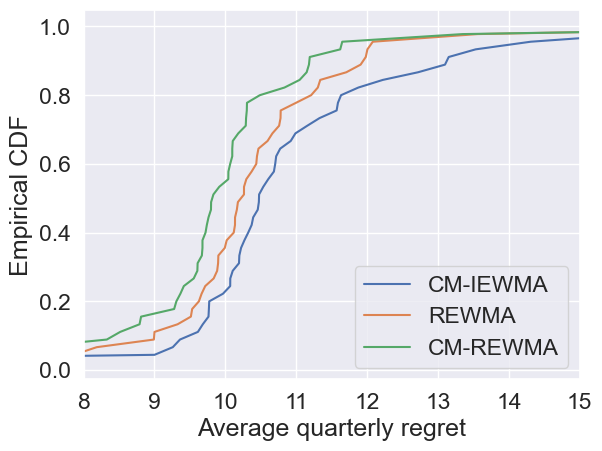

In [23]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(8,15)
# plt.ylim(-0.1,1.1)
plt.xlabel("Average quarterly regret")
plt.ylabel("Empirical CDF")
plt.legend();

In [24]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   CM-IEWMA & 11.0 & 2.7 & 23.7 \\
   REWMA & 10.4 & 1.9 & 19.3 \\
   CM-REWMA & 10.0 & 2.2 & 19.9 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


In [94]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   EWMA & 13.3 & 5.8 & 44.4 \\
   CM-IEWMA & 11.0 & 2.7 & 23.7 \\
   REWMA & 10.4 & 1.9 & 19.3 \\
   CM-REWMA & 9.9 & 2.2 & 19.3 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolios

In [25]:
from cvx.backtest.portfolios import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.1
excess = True

In [47]:
from experiments.utils.portfolio_backtests import *
from experiments.utils.portfolio_backtests import MeanVariance



### Equally weighted

In [27]:
traders_eq_w = EqWeighted(daily_returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 4/4 [01:12<00:00, 18.02s/it]


In [28]:
create_table(traders_eq_w, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.2\% & 9.9\% & 0.3 & 18\% \\
   REWMA & 3.7\% & 10.3\% & 0.4 & 16\% \\
   CM-REWMA & 4.4\% & 10.6\% & 0.4 & 16\% \\
   \hline
   PRESCIENT & 6.7\% & 9.9\% & 0.7 & 13\% \\
   \bottomrule
\end{tabular}


### Minimum risk

In [30]:
traders_min_risk = MinRisk(daily_returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 4/4 [01:00<00:00, 15.07s/it]


In [31]:
create_table(traders_min_risk, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 10.7\% & 11.0\% & 1.0 & 25\% \\
   REWMA & 10.7\% & 10.5\% & 1.0 & 21\% \\
   CM-REWMA & 12.0\% & 10.7\% & 1.1 & 21\% \\
   \hline
   PRESCIENT & 11.7\% & 10.0\% & 1.2 & 12\% \\
   \bottomrule
\end{tabular}


# Maximum diversification

In [34]:
traders_max_diverse = MaxDiverse(daily_returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 4/4 [00:30<00:00,  7.53s/it]


In [35]:
create_table(traders_max_diverse, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 3.6\% & 10.2\% & 0.4 & 25\% \\
   REWMA & 4.3\% & 10.5\% & 0.4 & 21\% \\
   CM-REWMA & 5.1\% & 10.8\% & 0.5 & 19\% \\
   \hline
   PRESCIENT & 7.8\% & 9.9\% & 0.8 & 16\% \\
   \bottomrule
\end{tabular}


### Risk parity

In [37]:
traders_risk_par = RiskParity(daily_returns, predictors, names, start_date, end_date).backtest()

 50%|█████     | 2/4 [00:14<00:14,  7.18s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 4/4 [00:30<00:00,  7.69s/it]


In [38]:
create_table(traders_risk_par, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 4.1\% & 10.0\% & 0.4 & 18\% \\
   REWMA & 4.7\% & 10.3\% & 0.5 & 17\% \\
   CM-REWMA & 5.5\% & 10.6\% & 0.5 & 17\% \\
   \hline
   PRESCIENT & 8.0\% & 9.9\% & 0.8 & 12\% \\
   \bottomrule
\end{tabular}


### Mean-variance

In [48]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

In [49]:
r_hat_ewma = pd.DataFrame(dict(_ewma_mean(daily_returns, halflife=250))).T
r_hat_ewma = tune_returns(r_hat_ewma)

mean_predictors = [r_hat_ewma for _ in names]

traders_mean_var = MeanVariance(daily_returns, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 4/4 [01:26<00:00, 21.67s/it]


In [50]:
create_table(traders_mean_var, None, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 8.6\% & 10.5\% & 0.8 & 22\% \\
   REWMA & 8.5\% & 10.3\% & 0.8 & 16\% \\
   CM-REWMA & 9.3\% & 10.5\% & 0.9 & 19\% \\
   \hline
   PRESCIENT & 10.9\% & 9.8\% & 1.1 & 21\% \\
   \bottomrule
\end{tabular}
